In [1]:
import matplotlib.pyplot as plt
import numpy as np
import d_evaluate
bs_bundle = d_evaluate.load_bootstrap_bundle()

AttributeError: module 'd_evaluate' has no attribute 'load_bootstrap'

In [ ]:
from x_config import config  # TODO!
NUM_BINS = config['num_bins']
BINS = np.arange(NUM_BINS)


In [ ]:
true_labels, predicted_probas = bs_bundle[0] # TEST

true_labels.shape, predicted_probas.shape

((601409,), (601409, 10))

In [ ]:
true_spectrum = d_evaluate.spectrum_from_labels(true_labels) # TODO: There is no single true spectrum, actually
true_spectra = [d_evaluate.spectrum_from_labels(single_bs[0]) for single_bs in bs_bundle]

# pred_spectrum = d_evaluate.spectrum_from_probas(predicted_probas)
pred_spectra = [d_evaluate.spectrum_from_probas(single_bs[1]) for single_bs in bs_bundle]


In [ ]:
from scipy.stats import wasserstein_distance

wd_list = np.array([wasserstein_distance(true_spectrum, single_pred_spectrum) for single_pred_spectrum in pred_spectra])
wd_list.mean(), wd_list.std()

(0.009959946914634522, 0.00463806202728874)

## volles Spektrum

In [ ]:
def plot_spectrum_all(true_spectra, pred_spectra, BINS, save=False):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))

    # plt.hist(BINS[:-1], BINS, weights=spectrum_from_labels(labels), color='red', label='true class')

    for i, single_true_spectrum in enumerate(true_spectra):
        axs[0].plot(BINS, single_true_spectrum, drawstyle='steps-mid', color='red',
                    linewidth=2, zorder=20, label=("true class" if i == 0 else None))
        # axs[0].plot(BINS, spectrum_from_labels(predicted_labels), drawstyle='steps-mid', color='royalblue', label='predicted class')

    for i, single_pred_spectrum in enumerate(pred_spectra):
        axs[0].plot(BINS, single_pred_spectrum, drawstyle='steps-mid', color='green',
                    alpha=0.5, zorder=10, label=("predicted probas" if i == 0 else None))

    avg_pred_spectrum = np.mean(pred_spectra, axis=0)
    axs[0].plot(BINS, avg_pred_spectrum, drawstyle='steps-mid', color='blue', zorder=20, label="predicted probas – average")

    axs[0].set_ylabel('count')
    axs[0].set_yscale('log')

    axs[1].axhline(0, color='red', linewidth=1)
    for i, (single_true_spectrum, single_pred_spectrum) in enumerate(zip(true_spectra, pred_spectra)):
        axs[1].plot(BINS, (single_pred_spectrum - single_true_spectrum) / single_true_spectrum, drawstyle='steps-mid',
                    color='blue',  alpha=0.5, label=("relative deviation" if i == 0 else None))

    for ax in axs:
        ax.set_xlabel('class')
        ax.set_xticks(BINS)
        ax.grid()
        ax.legend()

    fig.suptitle("bootstrap spectrum")
    fig.tight_layout()

    return fig


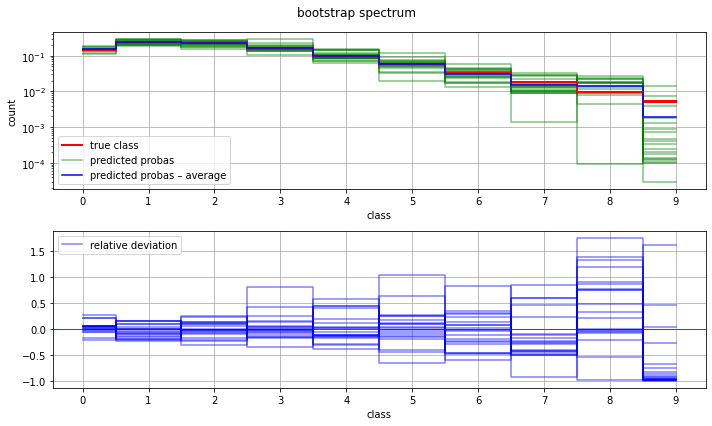

In [ ]:
fig = plot_spectrum_all(true_spectra, pred_spectra, BINS, save=False)
fig.savefig("bootstrap_spectrum_all.pdf")

/scratch/nweitkemper/envs/dsea/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/nweitkemper/envs/dsea/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/nweitkemper/envs/dsea/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

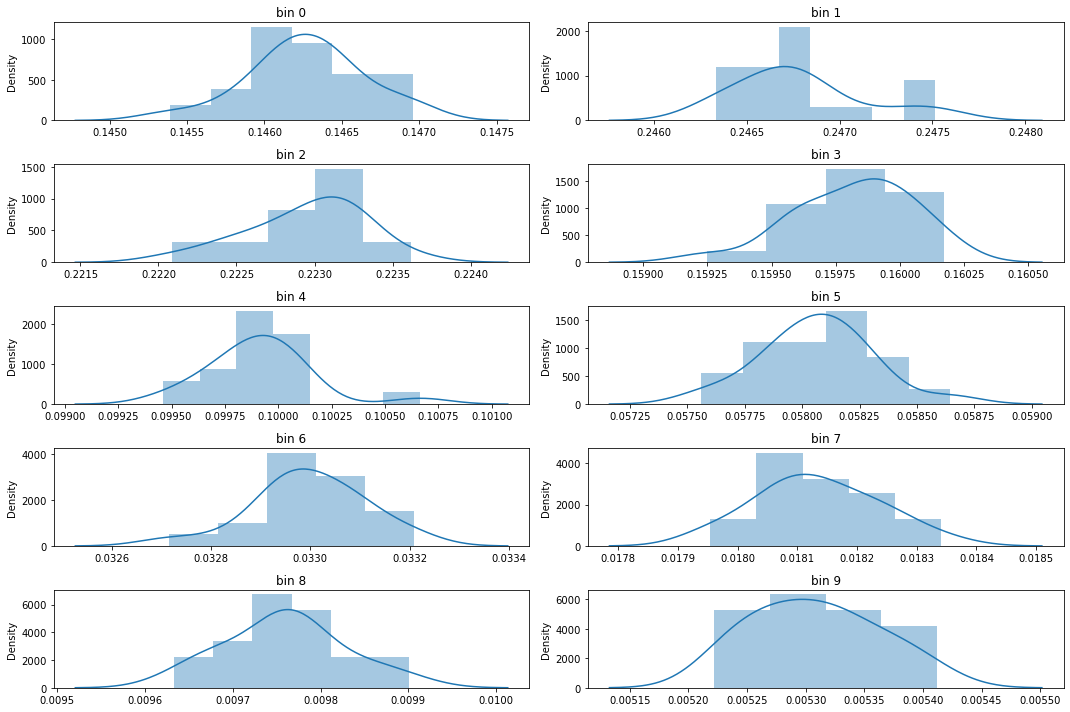

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(5, 2, figsize=(15, 10))
for bin_i in BINS:
    bin_counts = [np.sum(single_bs[1][single_bs[0] == bin_i]) / len(single_bs[1]) for single_bs in bs_bundle]
    # print(bin_i, bin_counts)
    
    # convert to np array
    bin_counts = np.array(bin_counts)

    ax = axs[bin_i // 2, bin_i % 2]
    sns.distplot(bin_counts, ax=ax)
    ax.set_title(f"bin {bin_i}")
fig.tight_layout()
# fig.savefig("bootstrap_distributions.pdf")

## Spektrum mit Errorbars

In [ ]:
# true_spectra = [d_evaluate.spectrum_from_labels(single_bs[0]) for single_bs in bs_bundle]
# pred_spectra = [d_evaluate.spectrum_from_probas(single_bs[1]) for single_bs in bs_bundle]

pred_spectra_stack = np.vstack(pred_spectra)

# █ mean / std
avg_pred_spectrum = np.mean(pred_spectra, axis=0)
pred_stds = np.std(pred_spectra_stack, axis=0)

# █ median / percentile
median_pred_spectrum = np.median(pred_spectra, axis=0)
PERCENTILE = 5
pred_percentiles = np.percentile(pred_spectra_stack, [PERCENTILE, 100-PERCENTILE], axis=0)

pred_percentiles_as_err = [
    # matplotlib expects [lower, upper]
    median_pred_spectrum - pred_percentiles[0],
    pred_percentiles[1] - median_pred_spectrum, 
]


median_pred_spectrum, pred_percentiles, pred_percentiles_as_err

(array([0.15062994, 0.2354151 , 0.22064057, 0.15829214, 0.09086814,
        0.0596188 , 0.0319325 , 0.01349482, 0.01369979, 0.00037817]),
 array([[1.22033051e-01, 1.94974014e-01, 1.72338352e-01, 1.30964065e-01,
         6.91683730e-02, 3.12913223e-02, 1.69243732e-02, 8.55614679e-03,
         4.24267025e-03, 9.63012573e-05],
        [1.77554025e-01, 2.85768814e-01, 2.75459554e-01, 2.32134149e-01,
         1.44093759e-01, 9.59034562e-02, 4.57510038e-02, 2.94555765e-02,
         2.35723154e-02, 7.96896073e-03]]),
 [array([0.02859689, 0.04044108, 0.04830221, 0.02732807, 0.02169977,
         0.02832748, 0.01500812, 0.00493867, 0.00945712, 0.00028187]),
  array([0.02692409, 0.05035372, 0.05481899, 0.07384201, 0.05322562,
         0.03628466, 0.01381851, 0.01596076, 0.00987252, 0.00759079])])

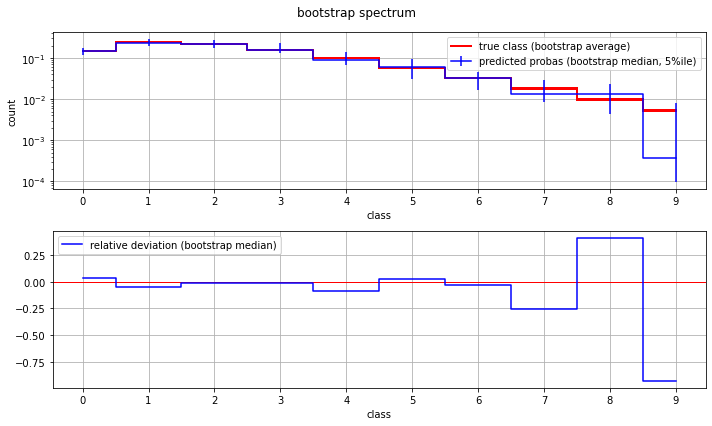

In [ ]:
def plot_spectrum_std(true_spectra, pred_spectra, BINS, save=False):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))

    # plt.hist(BINS[:-1], BINS, weights=spectrum_from_labels(labels), color='red', label='true class')

    # TODO: We plot all true spectra to verify that they are indistinguishable.
    # Since they are, just plot the average.
    for i, single_true_spectrum in enumerate(true_spectra):
        axs[0].plot(BINS, single_true_spectrum, drawstyle='steps-mid', color='red',
                    linewidth=2, zorder=20, label=("true class (bootstrap average)" if i == 0 else None))
        # axs[0].plot(BINS, spectrum_from_labels(predicted_labels), drawstyle='steps-mid', color='royalblue', label='predicted class')

    # for i, single_pred_spectrum in enumerate(pred_spectra):
    #     axs[0].errorbar(BINS, single_pred_spectrum, drawstyle='steps-mid', color='green',
    #                 alpha=0.5, zorder=10, label=("predicted probas" if i == 0 else None))

    axs[0].errorbar(BINS, 
                    # avg_pred_spectrum,
                    median_pred_spectrum,
                    # yerr=pred_stds,
                    # yerr=pred_percentiles,
                    yerr=pred_percentiles_as_err,
                    drawstyle='steps-mid', color='blue', zorder=20, label="predicted probas (bootstrap median, 5%ile)")

    axs[0].set_ylabel('count')
    axs[0].set_yscale('log')

    axs[1].axhline(0, color='red', linewidth=1)
    # for i, (single_true_spectrum, single_pred_spectrum) in enumerate(zip(true_spectra, pred_spectra)):
    #     axs[1].plot(BINS, (single_pred_spectrum - single_true_spectrum) / single_true_spectrum, drawstyle='steps-mid',
    #                 color='blue',  alpha=0.5, label=("relative deviation (per bootstrap iteration)" if i == 0 else None))
    
    axs[1].plot(BINS, np.median((np.array(pred_spectra) - np.array(true_spectra)) / np.array(true_spectra), axis=0), drawstyle='steps-mid',
                color='blue', label="relative deviation (bootstrap median)")

    for ax in axs:
        ax.set_xlabel('class')
        ax.set_xticks(BINS)
        ax.grid()
        ax.legend()

    fig.suptitle("bootstrap spectrum")
    fig.tight_layout()

    return fig


fig = plot_spectrum_std(true_spectra, pred_spectra, BINS, save=False);
fig.savefig("bootstrap_spectrum.pdf")

## Einzel-Events / Per-Bin-Spektren

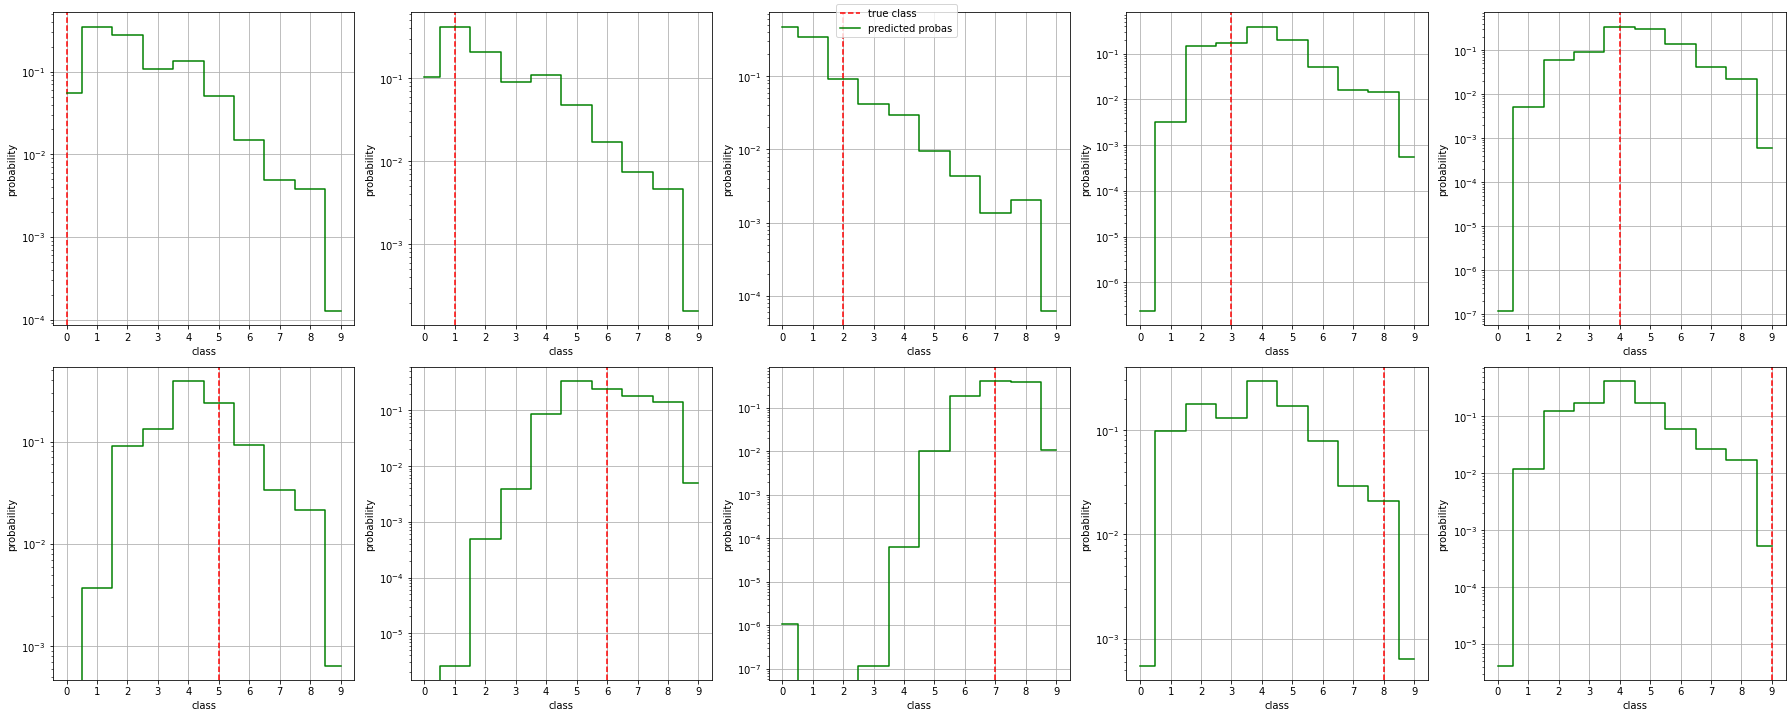

In [ ]:
import da_evaluate_plots
import importlib
importlib.reload(da_evaluate_plots)

fig = da_evaluate_plots.plot_single_events(*bs_bundle[0], BINS, save=False)
# fig.savefig("single_events.pdf")

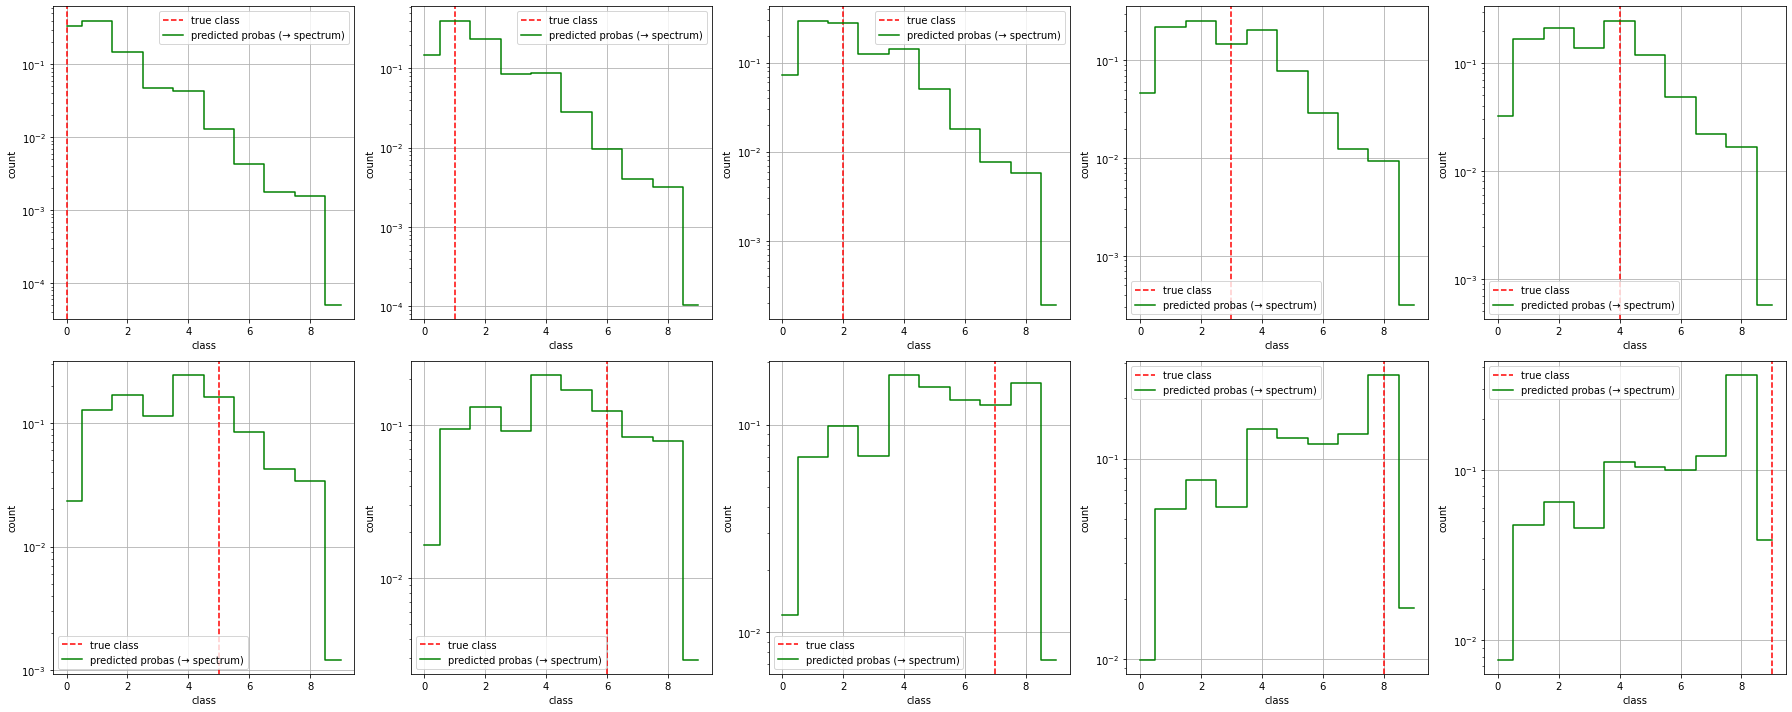

In [ ]:
import d_evaluate

def plot_per_bin_spectra():
    GRIDSIZE = (2, 5)
    fig, axs = plt.subplots(
        *GRIDSIZE,
        figsize=(GRIDSIZE[1] * 5, GRIDSIZE[0] * 5)
    )
    # TODO: iterate over bins instead of axes for clarity
    for i, ax in enumerate(axs.flat):
        if i >= len(BINS):
            ax.axis('off')
            continue

        ax.axvline(i, color='red', linestyle='--', label='true class')
        ax.plot(BINS, d_evaluate.spectrum_from_probas(predicted_probas[true_labels == i]),
                drawstyle='steps-mid', color='green', label='predicted probas (→ spectrum)')
        ax.set_xlabel('class')
        ax.set_ylabel('count')
        ax.set_yscale('log')
        ax.grid()
        ax.legend()
    fig.tight_layout()
    return fig

fig = plot_per_bin_spectra()
# fig.savefig('per_bin_spectra.pdf')

## Confusion-Matrix (nach argmax(y_pred))

In [ ]:
labels, predicted_probas = bs_bundle[0]

predicted_labels = np.argmax(predicted_probas, axis=1)
predicted_labels.shape, labels.shape

((601409,), (601409,))

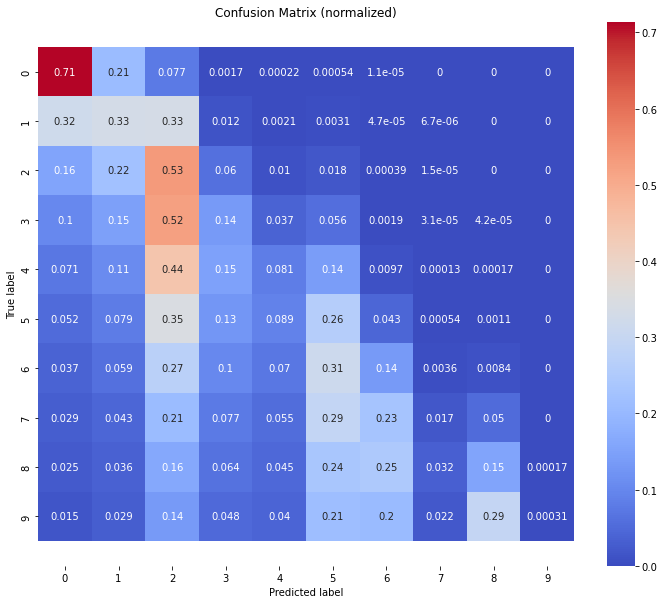

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion(labels, predicted_probas):
    # TODO: Use predicted_probas instead of predicted_labels
    predicted_labels = np.argmax(predicted_probas, axis=1)

    confusion_mtx = confusion_matrix(labels, predicted_labels)
    df_cm = pd.DataFrame(confusion_mtx/confusion_mtx.sum(axis=1)[:, np.newaxis])
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(df_cm, annot=True, cmap='coolwarm')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix (normalized)')
    return plt

bs_index = 2
plot_confusion(bs_bundle[bs_index][0], bs_bundle[bs_index][1]);